# Exploratory Analysis of Household Power Consumption



In [1]:
import pandas as pd
import os
os.chdir("/home/admin123/timeseries")
fp = "ln_hpc.txt"
df = pd.read_csv(fp, sep = ";")

/home/admin123/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Note:
The data has missing values in some columns. As part of data quality checking, we check that.

In [2]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

## Note:
In this analysis, we are only going to profile voltage, so we can drop the columns that are not needed - including sub_metering_3 which has some issues. It appears that NA values are encoded inconsitently in the data file. Sometimes they appear as NA and sometimes as ?. The values with ? indicate records/instants for which voltage data is not available. We will drop these from the analysis.

In [3]:
df[df["Voltage"] == "?"].head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN


In [4]:
df["Timestamp"] = df["Date"] + " " + df["Time"]
df["Timestamp"] = pd.to_datetime(df["Timestamp"],format="%d/%m/%Y %H:%M:%S")
df = df.set_index("Timestamp")

In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
df_prb = df[df.isnull().any(axis = 1)]

In [7]:
import numpy as np
prob_dates = np.unique(df_prb.index.date)

In [8]:
df_prb.shape

(25979, 9)

In [9]:
prob_dates[:10]

array([datetime.date(2006, 12, 21), datetime.date(2006, 12, 30),
       datetime.date(2007, 1, 14), datetime.date(2007, 1, 28),
       datetime.date(2007, 2, 22), datetime.date(2007, 3, 25),
       datetime.date(2007, 4, 28), datetime.date(2007, 4, 29),
       datetime.date(2007, 4, 30), datetime.date(2007, 6, 1)],
      dtype=object)

In [10]:
req_cols = ["Date", "Time", "Voltage"]
df = df[req_cols]
df = df[- (df["Voltage"] == "?")]
df.isnull().sum()

Date       0
Time       0
Voltage    0
dtype: int64

In [11]:
df["Voltage"] = df["Voltage"].astype('float')

In [12]:
df.columns

Index([u'Date', u'Time', u'Voltage'], dtype='object')

In [13]:

df = df[["Voltage"]]

In [14]:
df.isnull().sum()

Voltage    0
dtype: int64

In [15]:
df.columns

Index([u'Voltage'], dtype='object')

In [16]:
hourly_voltage = df.groupby(pd.Grouper(freq='H')).mean()

## Note:
The missing values cause problems for timeslots where hourly data is not available. These appear as na in the result. We will just drop these.

In [17]:
hourly_voltage.isnull().sum()

Voltage    421
dtype: int64

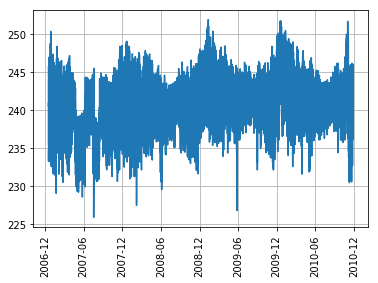

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline  
fig, ax = plt.subplots()
ax.plot(hourly_voltage.index, hourly_voltage)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation='vertical')
plt.grid()

## Observations
- A lot of spiky behavior at high frequency. This suggests possible noise or high frequency seasonal behavior. The data represents hourly mean voltages, so these short cycles (visually represent as spikes) could imply cyclic variation in hourly mean voltages.
- We can aggregate with larger time periods, for example, daily or weekly to see the kind of cyclic/seasonal behavior that manifests.

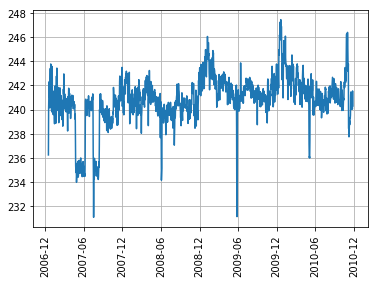

In [19]:
daily_voltage = df.groupby(pd.Grouper(freq='D')).mean()
daily_voltage = daily_voltage.dropna()
daily_voltage.index
fig, ax = plt.subplots()
ax.plot(daily_voltage.index, daily_voltage)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation='vertical')
plt.grid()

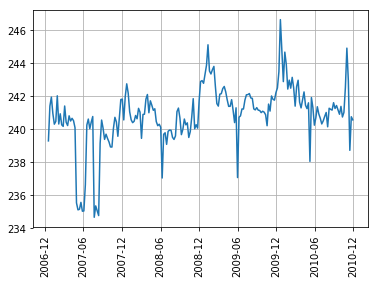

In [20]:
weekly_voltage = df.groupby(pd.Grouper(freq='W')).mean()
weekly_voltage = weekly_voltage.dropna()
fig, ax = plt.subplots()
ax.plot(weekly_voltage.index, weekly_voltage)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation='vertical')
plt.grid()

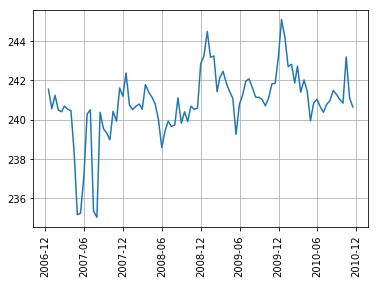

In [21]:
semimonthly_voltage = df.groupby(pd.Grouper(freq='SM')).mean()
semimonthly_voltage = semimonthly_voltage.dropna()
fig, ax = plt.subplots()
ax.plot(semimonthly_voltage.index, semimonthly_voltage)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation='vertical')
plt.grid()

## Observation
Clear increasing trend in the hourly mean voltage

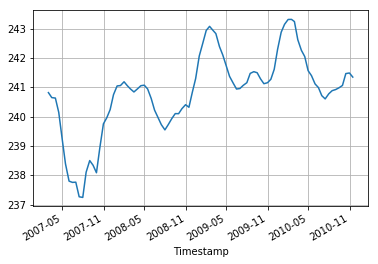

In [22]:
semimonthly_voltage["Voltage"].rolling(6).mean().plot()
plt.grid()

## Observations
- Perhaps a yearly cycle is present. Larger seasonalities (greater than a year) do not seem to be present

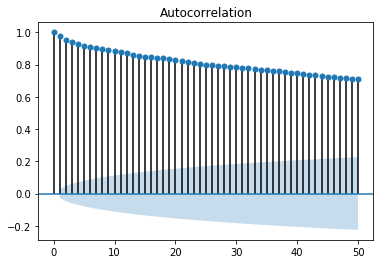

In [23]:
from statsmodels.graphics import tsaplots
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(df['Voltage'][:5000], lags=50)
plt.show()

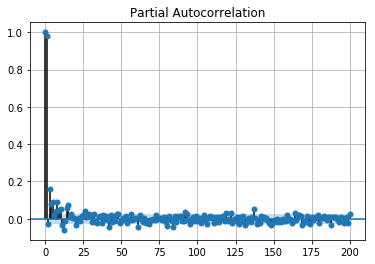

In [24]:
fig = tsaplots.plot_pacf(df['Voltage'][:5000], lags=200)
plt.grid()

## Observations
- Hourly mean voltages appear to have a seasonal behavior (the negative values of the pacf seemed to be spaced about 24 hours apart.)
- So hourly mean voltage appears to have strong seasonal and trend components. Let us extract this from the time series. We will do this analysis in a new notebook.